In [178]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sachchitkunichetty_rvf10k_path = kagglehub.dataset_download('sachchitkunichetty/rvf10k')

print('Data source import complete.')

Data source import complete.


In [179]:
#!pip install tensorflow numpy matplotlib seaborn scikit-learn opencv-python

In [180]:
# Setup and Configuration

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import KFold
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from typing import List, Tuple, Dict, Any
from tensorflow.keras import backend as K
import random
import glob
from tensorflow.keras.models import load_model
import math


CONFIG: Dict[str, Any] = {
    "SEED": 42,
    "IMAGE_SIZE": (224, 224),
    "BATCH_SIZE": 32,
    "N_FOLDS": 5,
    "DATA_DIR": r"/kaggle/input/rvf10k/rvf10k/train",
    "MODEL_SAVE_DIR": r"/kaggle/working/mymodels",

    "INITIAL_EPOCHS": 20,
    "FINE_TUNE_EPOCHS": 30,
    "INITIAL_LR": 0.001,
    "FINE_TUNE_LR": 1e-5,
    "L2_REG": 0.0001,
    "DROPOUT_RATE": 0.3,
    "ES_PATIENCE_PHASE1": 10,
    "RLR_PATIENCE_PHASE1": 4,
    "ES_PATIENCE_PHASE2": 15,
    "RLR_PATIENCE_PHASE2": 7,
    "MIN_LR": 1e-7,

    "PREDICTION_THRESHOLD": 0.5,
}

tf.random.set_seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])
random.seed(CONFIG["SEED"])
os.environ['PYTHONHASHSEED'] = str(CONFIG["SEED"])

os.makedirs(CONFIG["MODEL_SAVE_DIR"], exist_ok=True)

print("Environment and configuration loaded.")

Environment and configuration loaded.


In [181]:
# Data Loading and Preprocessing Functions

@tf.function
def apply_augmentation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return image

@tf.function
def preprocess_image(filepath: str, label: tf.Tensor, image_size: Tuple[int, int]) -> Tuple[tf.Tensor, tf.Tensor]:
    try:
        img = tf.io.read_file(filepath)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, image_size)
        img = tf.cast(img, tf.float32) / 255.0
        label = tf.reshape(tf.cast(label, tf.float32), (1,))
        return img, label
    except Exception as e:
        tf.print(f"Error processing image {filepath}: {e}")
        return tf.zeros(image_size + (3,), dtype=tf.float32), tf.constant([-1.0], dtype=tf.float32)

def load_data_paths(data_dir: str) -> Tuple[List[str], List[int]]:
    real_dir = os.path.join(data_dir, 'real')
    fake_dir = os.path.join(data_dir, 'fake')

    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        raise ValueError(f"Data directory must contain 'real' and 'fake' subdirectories. Looked in {data_dir}")

    real_paths = glob.glob(os.path.join(real_dir, '*.jpg')) + glob.glob(os.path.join(real_dir, '*.png'))
    fake_paths = glob.glob(os.path.join(fake_dir, '*.jpg')) + glob.glob(os.path.join(fake_dir, '*.png'))

    if not real_paths and not fake_paths:
         raise ValueError(f"No images found in 'real' or 'fake' subdirectories within {data_dir}. Check DATA_DIR configuration.")


    image_paths = real_paths + fake_paths
    labels = [0] * len(real_paths) + [1] * len(fake_paths)

    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined)

    print(f"Found {len(real_paths)} real and {len(fake_paths)} fake images.")

    return list(image_paths), list(labels)


def create_dataset(image_paths: List[str], labels: List[int], config: Dict[str, Any], is_training: bool = True) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, config["IMAGE_SIZE"]),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y: tf.not_equal(tf.reduce_sum(y), -1.0))

    if is_training:
        # dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=min(len(image_paths), 1000), seed=config["SEED"])
        dataset = dataset.map(lambda x, y: (apply_augmentation(x), y),
                              num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(config["BATCH_SIZE"])
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

Showing example images:


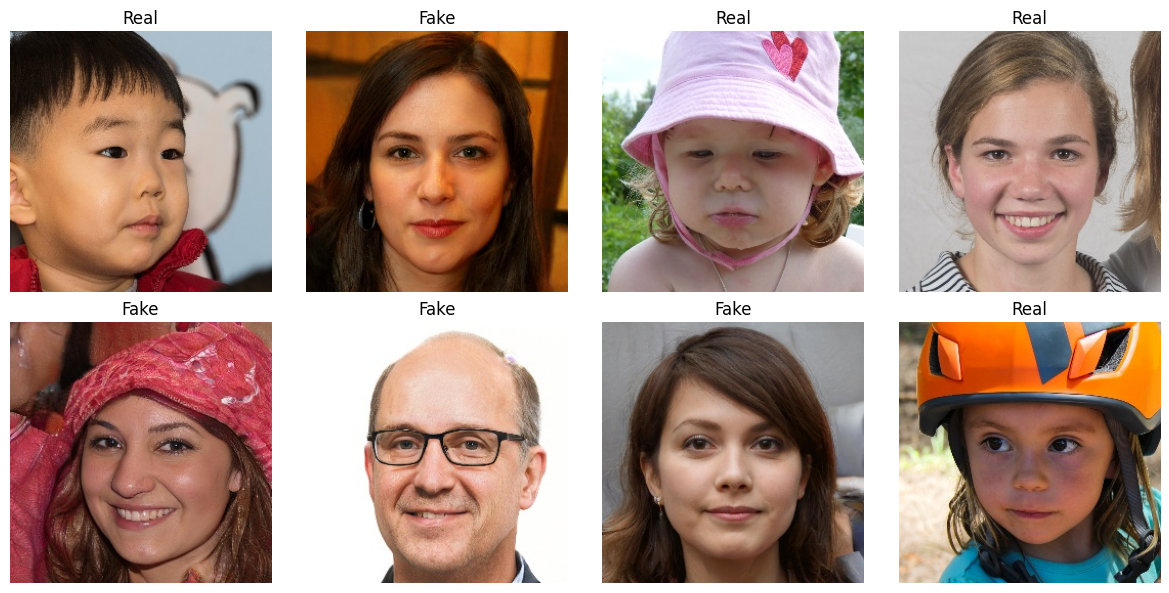

In [182]:
# Display Example Input Images

def display_example_images(data_dir: str, num_examples_per_class: int = 4):
    real_dir = os.path.join(data_dir, 'real')
    fake_dir = os.path.join(data_dir, 'fake')

    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        print(f"Error: Data directories not found. Check {data_dir}")
        return

    real_paths = glob.glob(os.path.join(real_dir, '*.jpg')) + glob.glob(os.path.join(real_dir, '*.png'))
    fake_paths = glob.glob(os.path.join(fake_dir, '*.jpg')) + glob.glob(os.path.join(fake_dir, '*.png'))

    if not real_paths and not fake_paths:
        print(f"No images found in {data_dir}.")
        return

    num_real_display = min(num_examples_per_class, len(real_paths))
    num_fake_display = min(num_examples_per_class, len(fake_paths))

    display_paths = random.sample(real_paths, num_real_display) + random.sample(fake_paths, num_fake_display)
    display_labels = ['Real'] * num_real_display + ['Fake'] * num_fake_display

    combined_display = list(zip(display_paths, display_labels))
    random.shuffle(combined_display)
    display_paths, display_labels = zip(*combined_display)

    total_display = len(display_paths)
    if total_display == 0:
        print("No images selected for display.")
        return

    ncols = 4
    nrows = math.ceil(total_display / ncols)

    plt.figure(figsize=(ncols * 3, nrows * 3))

    for i, (img_path, label) in enumerate(zip(display_paths, display_labels)):
        plt.subplot(nrows, ncols, i + 1)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
        except Exception as e:
            print(f"Could not display image {img_path}: {e}")
            plt.text(0.5, 0.5, f"Error\n{label}", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Showing example images:")
display_example_images(CONFIG["DATA_DIR"], num_examples_per_class=4)

In [183]:
# Model Architecture (XceptionNet)

def create_model(config: Dict[str, Any]) -> tf.keras.Model:
    base_model = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=config["IMAGE_SIZE"] + (3,),
        pooling=None
    )
    base_model.trainable = False

    inputs = layers.Input(shape=config["IMAGE_SIZE"] + (3,), name="input_layer")
    x = base_model(inputs, training=False)

    x = GlobalAveragePooling2D(name="global_avg_pooling")(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(CONFIG["L2_REG"]), name="dense_1")(x)
    x = BatchNormalization(name="batch_norm_1")(x)
    x = Dropout(CONFIG["DROPOUT_RATE"], name="dropout_1")(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(CONFIG["L2_REG"]), name="dense_2")(x)
    x = BatchNormalization(name="batch_norm_2")(x)
    x = Dropout(CONFIG["DROPOUT_RATE"], name="dropout_2")(x)

    outputs = Dense(1, activation='sigmoid', name="output_layer")(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="deepfake_classifier_xception")

    return model

In [184]:
# Training Function

def train_model(model: tf.keras.Model, train_ds: tf.data.Dataset, validation_ds: tf.data.Dataset,
                config: Dict[str, Any], fold_num: int) -> object:
    initial_epochs = config["INITIAL_EPOCHS"]
    fine_tune_epochs = config["FINE_TUNE_EPOCHS"]
    total_epochs = initial_epochs + fine_tune_epochs
    model_save_dir = config["MODEL_SAVE_DIR"]

    print(f"\n--- Fold {fold_num}: Phase 1 ---")
    model.compile(
        optimizer=Adam(learning_rate=config["INITIAL_LR"]),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(threshold=config["PREDICTION_THRESHOLD"], name='f1_score')
        ],
    )

    early_stopping_phase1 = EarlyStopping(monitor='val_loss', patience=config["ES_PATIENCE_PHASE1"], restore_best_weights=True, verbose=1)
    reduce_lr_phase1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=config["RLR_PATIENCE_PHASE1"], min_lr=config["MIN_LR"], verbose=1)
    checkpoint_filepath_phase1 = os.path.join(model_save_dir, f"fold_{fold_num}_phase1_best_model.keras")
    model_checkpoint_phase1 = ModelCheckpoint(filepath=checkpoint_filepath_phase1, save_best_only=True, monitor='val_loss', verbose=1)
    callbacks_phase1 = [early_stopping_phase1, reduce_lr_phase1, model_checkpoint_phase1]

    history_phase1 = model.fit(
        train_ds,
        epochs=initial_epochs,
        validation_data=validation_ds,
        callbacks=callbacks_phase1,
        verbose=1,
    )

    if os.path.exists(checkpoint_filepath_phase1):
         print(f"Loading best phase 1 weights for Fold {fold_num}.")
         model.load_weights(checkpoint_filepath_phase1)
    else:
         print(f"Warning: Phase 1 best weights not found for Fold {fold_num}.")


    print(f"\n Fold {fold_num}: Phase 2")
    model.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=config["FINE_TUNE_LR"]),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(threshold=config["PREDICTION_THRESHOLD"], name='f1_score')
        ],
    )

    early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=config["ES_PATIENCE_PHASE2"], restore_best_weights=True, verbose=1)
    reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=config["RLR_PATIENCE_PHASE2"], min_lr=config["MIN_LR"], verbose=1)
    checkpoint_filepath_phase2 = os.path.join(model_save_dir, f"fold_{fold_num}_phase2_best_model.keras")
    model_checkpoint_phase2 = ModelCheckpoint(filepath=checkpoint_filepath_phase2, save_best_only=True, monitor='val_loss', verbose=1)
    callbacks_phase2 = [early_stopping_phase2, reduce_lr_phase2, model_checkpoint_phase2]

    history_phase2 = model.fit(
        train_ds,
        epochs=total_epochs,
        initial_epoch=initial_epochs,
        validation_data=validation_ds,
        callbacks=callbacks_phase2,
        verbose=1,
    )

    combined_history = {}
    for key in history_phase1.history.keys():
        combined_history[key] = history_phase1.history[key] + history_phase2.history.get(key, [])

    class CombinedHistory:
        def __init__(self, history_dict):
            self.history = history_dict

    return CombinedHistory(combined_history)

In [185]:
# Evaluation and Plotting Functions

def evaluate_model(model: tf.keras.Model, validation_ds: tf.data.Dataset, config: Dict[str, Any], fold_num: Any) -> Tuple[np.ndarray, np.ndarray]:
    print(f"\n--- Evaluation for {('Fold ' + str(fold_num)) if isinstance(fold_num, int) else fold_num} ---")

    y_true_list = []
    y_pred_list = []

    print("Collecting predictions...")
    for batch_images, batch_labels in validation_ds:
        y_true_list.extend(batch_labels.numpy().flatten())
        y_pred_batch = model.predict(batch_images, verbose=0)
        y_pred_list.extend(y_pred_batch.flatten().tolist())

    y_true = np.array(y_true_list)
    y_pred = np.array(y_pred_list)
    y_pred_binary = (y_pred > config["PREDICTION_THRESHOLD"]).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_binary, zero_division=0))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{("Fold " + str(fold_num)) if isinstance(fold_num, int) else fold_num} Confusion Matrix')
    plt.show()

    return y_true, y_pred


def plot_history(history: object, fold_num: Any) -> None:
    hist = history.history

    if not hist:
        print(f"No history data to plot for {('Fold ' + str(fold_num)) if isinstance(fold_num, int) else fold_num}.")
        return

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(hist.get('loss', []), label='Training Loss')
    plt.plot(hist.get('val_loss', []), label='Validation Loss')
    plt.title(f'{("Fold " + str(fold_num)) if isinstance(fold_num, int) else fold_num} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.subplot(1, 2, 2)
    plt.plot(hist.get('accuracy', []), label='Training Accuracy')
    plt.plot(hist.get('val_accuracy', []), label='Validation Accuracy')
    plt.title(f'{("Fold " + str(fold_num)) if isinstance(fold_num, int) else fold_num} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true: np.ndarray, y_pred: np.ndarray, fold_num: Any) -> None:
    if len(np.unique(y_true)) < 2:
        print(f"Skipping ROC plot for {('Fold ' + str(fold_num)) if isinstance(fold_num, int) else fold_num}: Only one class present in true labels.")
        return

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{("Fold " + str(fold_num)) if isinstance(fold_num, int) else fold_num} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--')
    plt.show()

In [186]:
# Prediction Functions

def load_trained_model(model_path: str) -> tf.keras.Model:
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    print(f"Loading model from: {model_path}")
    model = load_model(model_path)
    print("Model loaded.")
    return model


def predict_single_image(model: tf.keras.Model, image_path: str, config: Dict[str, Any]) -> Tuple[float, str]:
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at: {image_path}")
        plt.figure(figsize=(6, 6))
        plt.text(0.5, 0.5, "Error: Image not found", horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        plt.axis('off')
        plt.title("Prediction Error")
        plt.show()
        return -1.0, "Error"

    try:
        img_tensor, _ = preprocess_image(tf.constant(image_path), tf.constant(0), config["IMAGE_SIZE"])
        img_tensor = tf.expand_dims(img_tensor, axis=0)
    except Exception as e:
         print(f"Error processing image {image_path} for prediction: {e}")
         plt.figure(figsize=(6, 6))
         plt.text(0.5, 0.5, f"Error processing image:\n{e}", horizontalalignment='center', verticalalignment='center', fontsize=10, color='red')
         plt.axis('off')
         plt.title("Image Processing Error")
         plt.show()
         return -1.0, "Error"

    prediction_prob = model.predict(img_tensor, verbose=0)[0][0]
    predicted_class = 'Fake' if prediction_prob > config["PREDICTION_THRESHOLD"] else 'Real'

    try:
        img_display = cv2.imread(image_path)
        if img_display is not None:
            img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(6, 6))
            plt.imshow(img_display)
            plt.title(f"Prediction: {predicted_class} (Prob: {prediction_prob:.4f})")
            plt.axis('off')
            plt.show()
        else:
             print(f"Could not read image file for display: {image_path}")
             plt.figure(figsize=(6, 6))
             plt.text(0.5, 0.5, "Image Display Failed", horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
             plt.title("Prediction (Image Display Failed)")
             plt.axis('off')
             plt.show()

    except Exception as e:
        print(f"Could not display image for visualization: {e}")

    print(f"Prediction for {os.path.basename(image_path)}: Prob (Fake) = {prediction_prob:.4f}, Predicted = {predicted_class}")

    return float(prediction_prob), predicted_class


def predict_on_directory(model: tf.keras.Model, directory_path: str, config: Dict[str, Any]) -> List[Tuple[str, float, str]]:
    if not os.path.exists(directory_path) or not os.path.isdir(directory_path):
        print(f"Error: Directory not found: {directory_path}")
        return []

    image_files = glob.glob(os.path.join(directory_path, '*.jpg')) + glob.glob(os.path.join(directory_path, '*.png'))

    if not image_files:
        print(f"No images found in {directory_path}.")
        return []

    print(f"Found {len(image_files)} images in {directory_path}. Predicting...")

    dummy_labels = [0] * len(image_files)
    predict_ds = create_dataset(image_files, dummy_labels, config, is_training=False)
    predict_ds = predict_ds.map(lambda image, label: image)

    predictions = model.predict(predict_ds, verbose=1)

    results = []
    for i, prob in enumerate(predictions.flatten()):
        image_path = image_files[i]
        filename = os.path.basename(image_path)
        predicted_class = 'Fake' if prob > config["PREDICTION_THRESHOLD"] else 'Real'
        results.append((filename, float(prob), predicted_class))

    print("Predictions complete.")
    return results

In [187]:
# Main Execution Logic

def main(config: Dict[str, Any], mode: str = 'train') -> None:
    print(f"Starting {mode} mode")

    if mode == 'train':
        print("Preparing data for training...")
        try:
            image_paths, labels = load_data_paths(config["DATA_DIR"])
        except ValueError as e:
            print(f"Error loading data: {e}")
            return

        labels_np = np.array(labels)
        image_paths_np = np.array(image_paths)

        kf = KFold(n_splits=config["N_FOLDS"], shuffle=True, random_state=config["SEED"])

        all_y_true = []
        all_y_pred = []
        fold_metrics: Dict[str, List[float]] = {
            'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc': []
        }

        for fold_count, (train_index, val_index) in enumerate(kf.split(image_paths_np, labels_np), 1):
            print(f"\n\n--- Starting Fold {fold_count}/{config['N_FOLDS']} ---")

            train_paths, train_labels = image_paths_np[train_index], labels_np[train_index]
            val_paths, val_labels = image_paths_np[val_index], labels_np[val_index]

            if len(np.unique(train_labels)) < 2:
                 print(f"Skipping Fold {fold_count}: Only one class in training set.")
                 continue
            if len(np.unique(val_labels)) < 2:
                 print(f"Warning: Only one class in validation set for Fold {fold_count}.")


            train_ds = create_dataset(list(train_paths), list(train_labels), config, is_training=True)
            validation_ds = create_dataset(list(val_paths), list(val_labels), config, is_training=False)

            model = create_model(config)
            history = train_model(model, train_ds, validation_ds, config, fold_count)

            best_model_path = os.path.join(config["MODEL_SAVE_DIR"], f"fold_{fold_count}_phase2_best_model.keras")
            if os.path.exists(best_model_path):
                 print(f"\nLoading best weights for Fold {fold_count} for evaluation.")
                 model.load_weights(best_model_path)
            else:
                 print(f"\nWarning: Best model weights not found for Fold {fold_count}.")

            y_true_fold, y_pred_fold = evaluate_model(model, validation_ds, config, fold_count)

            all_y_true.extend(y_true_fold)
            all_y_pred.extend(y_pred_fold)

            plot_history(history, fold_count)
            plot_roc_curve(y_true_fold, y_pred_fold, fold_count)

            y_pred_binary_fold = (y_pred_fold > config["PREDICTION_THRESHOLD"]).astype(int)
            report = classification_report(y_true_fold, y_pred_binary_fold, output_dict=True, zero_division=0)

            fold_metrics['accuracy'].append(report.get('accuracy', 0.0))
            if '1' in report:
                 fold_metrics['precision'].append(report['1']['precision'])
                 fold_metrics['recall'].append(report['1']['recall'])
                 fold_metrics['f1_score'].append(report['1']['f1-score'])
            else:
                 fold_metrics['precision'].append(0.0)
                 fold_metrics['recall'].append(0.0)
                 fold_metrics['f1_score'].append(0.0)


            if len(np.unique(y_true_fold)) > 1:
                fold_metrics['auc'].append(auc(*roc_curve(y_true_fold, y_pred_fold)[:2]))
            else:
                 fold_metrics['auc'].append(0.0)


            del model
            K.clear_session()
            print(f"\n Finished Fold {fold_count} \n")

        print(f"\n\n K-Fold Cross-Validation Summary")
        print("\n Average Performance Across Folds:")
        for metric_name, values in fold_metrics.items():
            if values:
                print(f"Average {metric_name.replace('_', '-').title()}: {np.mean(values):.4f} ± {np.std(values):.4f}")
            else:
                print(f"No data collected for {metric_name.replace('_', '-').title()}")

        print("\n Overall Metrics (Pooled Predictions):")
        if all_y_true:
            all_y_true_np = np.array(all_y_true)
            all_y_pred_np = np.array(all_y_pred)
            all_y_pred_binary_np = (all_y_pred_np > config["PREDICTION_THRESHOLD"]).astype(int)

            if len(np.unique(all_y_true_np)) > 1:
                 print(classification_report(all_y_true_np, all_y_pred_binary_np, zero_division=0))
                 cm_overall = confusion_matrix(all_y_true_np, all_y_pred_binary_np)
                 plt.figure(figsize=(8, 6))
                 sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
                 plt.xlabel('Predicted Labels')
                 plt.ylabel('True Labels')
                 plt.title('Overall Confusion Matrix')
                 plt.show()
                 plot_roc_curve(all_y_true_np, all_y_pred_np, fold_num='Overall Pooled')
            else:
                 print("Cannot compute overall metrics: Only one class in pooled true labels.")
        else:
            print("No evaluation data collected.")

    elif mode == 'predict_dir':
        print("Running directory prediction...")
        model_to_use = os.path.join(config["MODEL_SAVE_DIR"], "fold_4_phase2_best_model.keras") # Update fold number if needed
        directory_to_predict = r"/kaggle/input/imagetest2/test2" # Update path if needed

        if not os.path.exists(model_to_use):
            print(f"Error: Model file not found at {model_to_use}.")
            return

        try:
            model = load_trained_model(model_to_use)
            results = predict_on_directory(model, directory_to_predict, config)
            if results:
                 print("\n Prediction Results")
                 for filename, prob, label in results:
                     print(f"{filename}: Prob (Fake) = {prob:.4f}, Predicted = {label}")
            else:
                 print("No predictions made.")
            del model
            K.clear_session()

        except (ValueError, FileNotFoundError) as e:
            print(f"Prediction Error: {e}")
        except Exception as e:
            print(f"An error occurred during directory prediction: {e}")

    else:
        print(f"Error: Unknown mode: {mode}. Use 'train' or 'predict_dir'.")

    print("\n Project Finished")

In [188]:
# Choose and Execute Project Mode

# Uncomment one of the lines below to run the desired mode

# main(CONFIG, mode='train') # Run K-Fold Training (if you wanna train the model)

#Or,

main(CONFIG, mode='predict_dir') # To Predict using trained model (predicting different dataset (which's not trained on) images)

Starting predict_dir mode
Running directory prediction...
Loading model from: /kaggle/working/mymodels/fold_4_phase2_best_model.keras
Model loaded.
Found 120 images in /kaggle/input/imagetest2/test2. Predicting...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Predictions complete.

 Prediction Results
real (32).jpg: Prob (Fake) = 0.0499, Predicted = Real
fake (33).jpg: Prob (Fake) = 0.8890, Predicted = Fake
fake (14).jpg: Prob (Fake) = 0.9223, Predicted = Fake
real (42).jpg: Prob (Fake) = 0.3792, Predicted = Real
real (14).jpg: Prob (Fake) = 0.2058, Predicted = Real
fake (43).jpg: Prob (Fake) = 0.9000, Predicted = Fake
real (39).jpg: Prob (Fake) = 0.2248, Predicted = Real
fake (26).jpg: Prob (Fake) = 0.2774, Predicted = Real
fake (52).jpg: Prob (Fake) = 0.7809, Predicted = Fake
real (29).jpg: Prob (Fake) = 0.0361, Predicted = Real
real (10).jpg: Prob (Fake) = 0.6046, Predicted = Fake
fake (13).jpg: Prob (Fake) = 0.4550, Predicted = Real
real (13).jpg: Prob (Fake) = 0.0306, Predicted = Real
real 

Attempting to load model from: /kaggle/working/mymodels/fold_4_phase2_best_model.keras
Loading model from: /kaggle/working/mymodels/fold_4_phase2_best_model.keras
Model loaded.

Making predictions for 2 images:

 Predicting on Image 1/2: 0M0F4YJ1G9.jpg -----


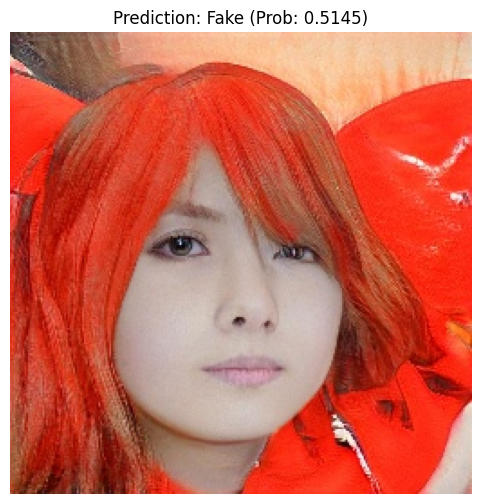

Prediction for 0M0F4YJ1G9.jpg: Prob (Fake) = 0.5145, Predicted = Fake

 Predicting on Image 2/2: 00292.jpg -----


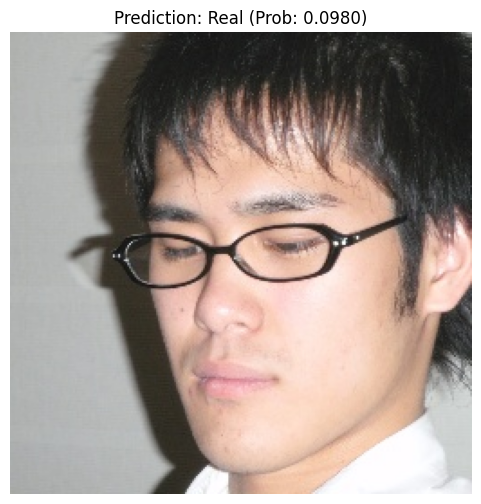

Prediction for 00292.jpg: Prob (Fake) = 0.0980, Predicted = Real


In [189]:
# Predict and Visualize Multiple Images

import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

model_filename = "fold_4_phase2_best_model.keras" #update if needed
model_path_for_prediction = os.path.join(CONFIG["MODEL_SAVE_DIR"], model_filename)


# Specify the paths to the images you want to predict on
image_paths_for_prediction = [
    r"/kaggle/input/rvf10k/rvf10k/train/fake/0M0F4YJ1G9.jpg", #update if needed
    r"/kaggle/input/rvf10k/rvf10k/train/real/00292.jpg",      #update if needed
    # Add more image paths to this list with the same indentation as the lines above
]

# Load the model
print(f"Attempting to load model from: {model_path_for_prediction}")
try:
    prediction_model = load_trained_model(model_path_for_prediction)
    model_loaded_successfully = True
except FileNotFoundError:
    print(f"\n Error: Model file not found at {model_path_for_prediction}.")
    print("Please ensure you have trained a model and the path is correct.")
    model_loaded_successfully = False # Flag failure
    prediction_model = None # Explicitly set to None
except Exception as e:
    print(f"\n An error occurred while loading the model: {e}")
    model_loaded_successfully = False # Flag failure
    prediction_model = None


#  Make and Visualize Predictions (if model loaded successfully)
if model_loaded_successfully and prediction_model:
    print(f"\nMaking predictions for {len(image_paths_for_prediction)} images:")
    for i, image_path in enumerate(image_paths_for_prediction):
        print(f"\n Predicting on Image {i+1}/{len(image_paths_for_prediction)}: {os.path.basename(image_path)} -----")
        prob, label = predict_single_image(prediction_model, image_path, CONFIG)

else:
    print("\n Skipping prediction as the model could not be loaded.")